**[MDR-01]** 必要なモジュールをインポートします。

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

# jupyter notebook上にグラフを表示するために必要
%matplotlib inline

**[MDR-02]** MNISTのデータセットを用意します。

In [2]:
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


**[MDR-03]** フィルターに対応する Variable を用意して、入力データにフィルターとプーリング層を適用する計算式を定義します。

In [3]:
num_filters = 16

x = tf.placeholder(tf.float32, [None, 784])
x_image = tf.reshape(x, [-1,28,28,1])

W_conv = tf.Variable(tf.truncated_normal([5,5,1,num_filters], stddev=0.1))
h_conv = tf.nn.conv2d(x_image, W_conv,
                      strides=[1,1,1,1], padding='SAME')
h_pool =tf.nn.max_pool(h_conv, ksize=[1,2,2,1],
                       strides=[1,2,2,1], padding='SAME')

**[MDR-04]** プーリング層からの出力を全結合層を経由してソフトマックス関数に入力する計算式を定義します。

In [4]:
h_pool_flat = tf.reshape(h_pool, [-1, 14*14*num_filters])

num_units1 = 14*14*num_filters
num_units2 = 1024

w2 = tf.Variable(tf.truncated_normal([num_units1, num_units2]))
b2 = tf.Variable(tf.zeros([num_units2]))
hidden2 = tf.nn.relu(tf.matmul(h_pool_flat, w2) + b2)

w0 = tf.Variable(tf.zeros([num_units2, 10]))
b0 = tf.Variable(tf.zeros([10]))
p = tf.nn.softmax(tf.matmul(hidden2, w0) + b0)

**[MDR-05]** 誤差関数 loss、トレーニングアルゴリズム train_step、正解率 accuracy を定義します。

In [5]:
t = tf.placeholder(tf.float32, [None, 10])
loss = -tf.reduce_sum(t * tf.log(p))
train_step = tf.train.AdamOptimizer(0.0005).minimize(loss)
correct_prediction = tf.equal(tf.argmax(p, 1), tf.argmax(t, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

**[MDR-06]** セッションを用意して Variable を初期化した後、最適化処理を実施済みのセッションを復元します。

In [6]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.restore(sess, './mdc_session-4000')

**[MDR-07]** 畳込みフィルターの値と、最初の9個分の画像データに対して、畳み込みフィルターとプーリング層を適用した結果を取得します。

In [7]:
filter_vals, conv_vals, pool_vals = sess.run(
    [W_conv, h_conv, h_pool], feed_dict={x:mnist.test.images[:9]})

**[MDR-08]** 畳込みフィルターを適用した結果を画像として表示します。

畳込みフィルターを適用した後は、ピクセル値が負の値をとることもあるため、背景（ピクセル値 0）の部分が白にならない点に注意してください。

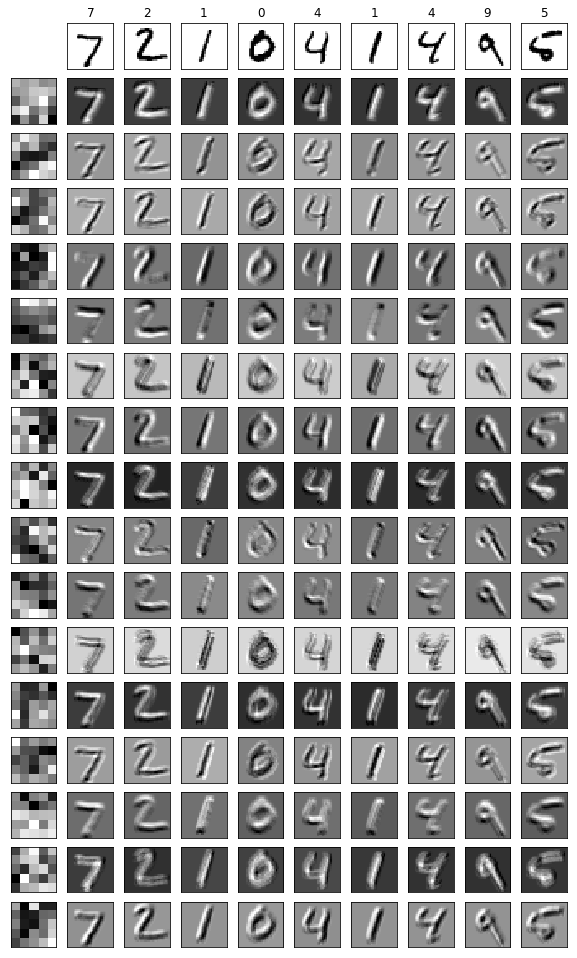

In [8]:
fig = plt.figure(figsize=(10,num_filters+1))

for i in range(num_filters):
    subplot = fig.add_subplot(num_filters+1, 10, 10*(i+1)+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(filter_vals[:,:,0,i],
                   cmap=plt.cm.gray_r, interpolation='nearest')

for i in range(9):
    subplot = fig.add_subplot(num_filters+1, 10, i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('%d' % np.argmax(mnist.test.labels[i]))
    subplot.imshow(mnist.test.images[i].reshape((28,28)),
                   vmin=0, vmax=1,
                   cmap=plt.cm.gray_r, interpolation='nearest')

    for f in range(num_filters):
        subplot = fig.add_subplot(num_filters+1, 10, 10*(f+1)+i+2)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.imshow(conv_vals[i,:,:,f],
                       cmap=plt.cm.gray_r, interpolation='nearest')    

**[MDR-09]** 同じく、畳込みフィルターとプーリング層を適用した結果を画像として表示します。

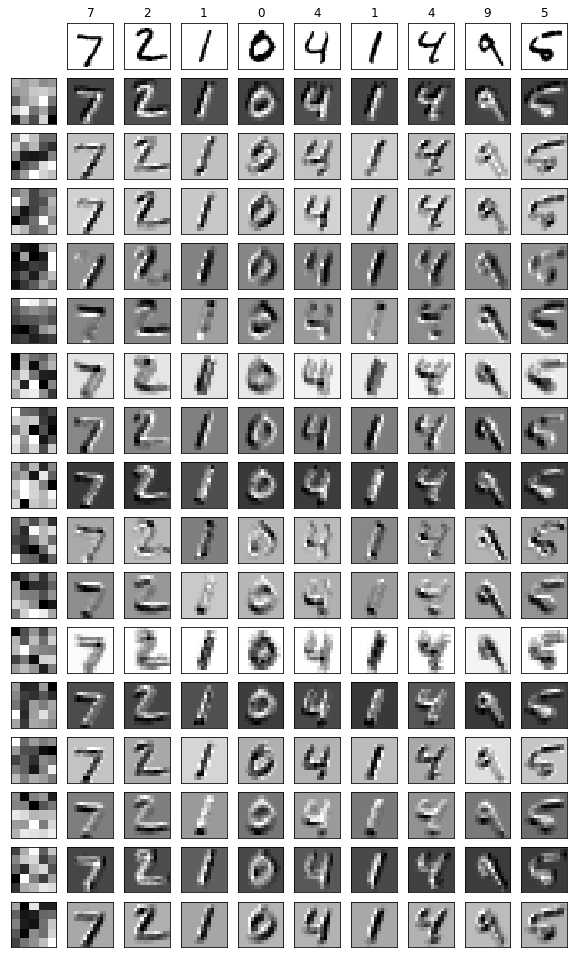

In [9]:
fig = plt.figure(figsize=(10,num_filters+1))

for i in range(num_filters):
    subplot = fig.add_subplot(num_filters+1, 10, 10*(i+1)+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(filter_vals[:,:,0,i],
                   cmap=plt.cm.gray_r, interpolation='nearest')

for i in range(9):
    subplot = fig.add_subplot(num_filters+1, 10, i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('%d' % np.argmax(mnist.test.labels[i]))
    subplot.imshow(mnist.test.images[i].reshape((28,28)),
                   vmin=0, vmax=1,
                   cmap=plt.cm.gray_r, interpolation='nearest')

    for f in range(num_filters):
        subplot = fig.add_subplot(num_filters+1, 10, 10*(f+1)+i+2)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.imshow(pool_vals[i,:,:,f],
                       cmap=plt.cm.gray_r, interpolation='nearest') 

**[MDR-10]** 正しく分類できなかったいくつかのデータについて、それぞれの文字である確率を確認します。

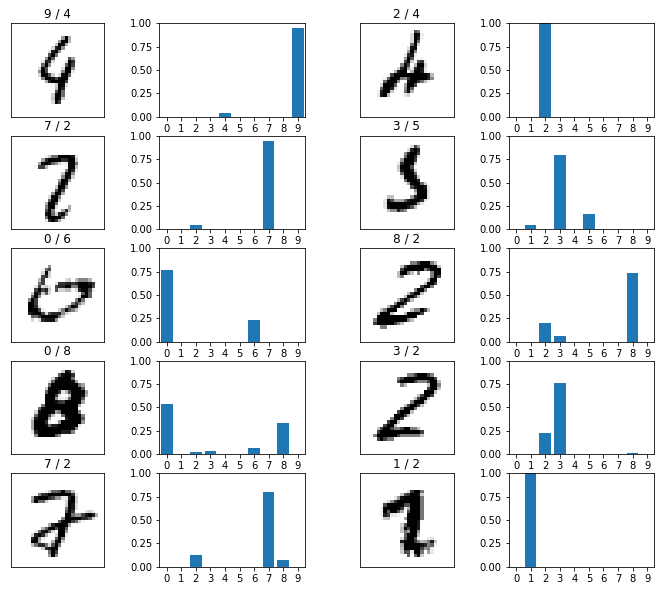

In [10]:
fig = plt.figure(figsize=(12,10))
c=0
for (image, label) in zip(mnist.test.images, 
                          mnist.test.labels):
    p_val = sess.run(p, feed_dict={x:[image]})
    pred = p_val[0]
    prediction, actual = np.argmax(pred), np.argmax(label)
    if prediction == actual:
        continue
    subplot = fig.add_subplot(5,4,c*2+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('%d / %d' % (prediction, actual))
    subplot.imshow(image.reshape((28,28)), vmin=0, vmax=1,
                   cmap=plt.cm.gray_r, interpolation="nearest")
    subplot = fig.add_subplot(5,4,c*2+2)
    subplot.set_xticks(range(10))
    subplot.set_xlim(-0.5,9.5)
    subplot.set_ylim(0,1)
    subplot.bar(range(10), pred, align='center')
    c += 1
    if c == 10:
        break